In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


In [2]:
path = 'results_P1B1_cor0.85'
# path = 'results_P1B1_cor0.9'
APP = 'P1B1'

In [3]:
# rf_fi  = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fi.csv'))
# rfv_fi = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fi_var.csv'))
# rfs_fi = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fi_score.csv'))

# fip = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fi_score_p.csv'))
##fimap = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fi_score_pmap.csv'))
fimap = pd.read_csv(os.path.join(file_path, path, f'{APP}_rf_fimap.csv'))

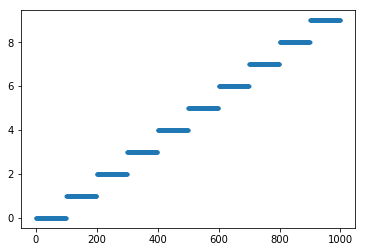

In [4]:
DATAPATH_TR = os.path.join(file_path, 'data', f'P1B1.dev.train.lincs.ap')
DATAPATH_VL = os.path.join(file_path, 'data', f'P1B1.dev.test.lincs.ap')
YENC_PATH = os.path.join(file_path, 'data', f'P1B1.y.enc.ap')

data_train = pd.read_csv(DATAPATH_TR, sep='\t')
data_val = pd.read_csv(DATAPATH_VL, sep='\t')
y_enc = pd.read_csv(YENC_PATH, sep='\t')

# xtr = data_train.iloc[:, 1:].copy()
# ytr = data_train.iloc[:, 0].copy()
# xvl = data_val.iloc[:, 1:].copy()
yvl = data_val.iloc[:, 0].copy().values
# features = xtr.columns
plt.plot(yvl, '.');

In [5]:
data_train[:3]

,y,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,9,20.0,15.2,16.3,19.2,18.0,17.1,16.3,19.0,17.0,...,17.6,17.3,16.9,16.1,16.3,17.9,15.5,16.0,16.5,17.3
1,0,21.0,14.8,15.7,18.8,18.1,19.2,18.5,19.3,18.0,...,19.1,17.3,16.2,16.7,16.8,17.4,15.6,14.2,16.6,17.0
2,8,21.2,13.7,14.3,18.5,17.9,17.6,16.5,18.9,17.7,...,18.7,17.1,16.0,17.1,17.0,17.9,15.8,15.4,16.4,17.1


### Throw away all the correlated features

In [8]:
def find_cor_cols(fi):
    # fi = fi.loc[fi['n']>1, 'cols']
    cols_to_drop = []
    # for col_set in fi['cols'].tolist():
    for col_set in fi.columns.tolist():
        if len(col_set.split(',')) > 1:
            col = np.array(col_set.split(','))
            cols_to_drop.extend(col)
    return cols_to_drop

In [9]:
len(find_cor_cols(fi=fimap))
# len(find_cor_cols(fi=rfs_fi))

28

In [10]:
# col_sets = rfv_fi.loc[rfv_fi['n']>1, 'cols'].tolist()
# col_sets
        
colsets_to_drop = [c for c in fimap.columns.tolist() if (len(c.split(',')) > 1)]
colsets_to_drop

['AURKA,AURKB,BIRC5,BUB1B,CCNA2,CCNB1,CCNB2,CDK1,KIF20A,KIF2C,MELK,MYBL2,NUSAP1,ORC1,PLK1,UBE2C',
 'CDC20,CDC45,E2F2',
 'CENPE,KIF14,TOP2A',
 'HLA-DMA,HLA-DRA',
 'IKZF1,PTPRC',
 'PSME1,PSME2']

In [11]:
print(fimap.shape)
fimap = fimap.drop(columns=colsets_to_drop)
print(fimap.shape)

(1000, 953)
(1000, 947)


In [12]:
# fimap = fimap.loc[:, sorted(fimap.columns)]

### analysis per class

In [13]:
y_enc

,code,label
0,0,Brain [LGG]
1,1,Breast [BRCA]
2,2,Head&Neck [HNSC]
3,3,Lung [LUAD]
4,4,Lung [LUSC]
5,5,Others
6,6,Prostate [PRAD]
7,7,Skin [SKCM]
8,8,Thyroid [THCA]
9,9,Uterine [UCEC]


In [ ]:
# Add the label code and label name columns
y_enc_dict = {y_enc.loc[i, 'code']: y_enc.loc[i, 'label'] for i in range(len(y_enc))}
fimap.insert(loc=0, column='y', value=yvl)
fimap.insert(loc=1, column='label', value=[y_enc_dict[c] for c in yvl])
print(fimap.shape)

In [15]:
fimap[:3]

,y,label,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,0,Brain [LGG],0.004281,-1.110223e-16,0.003875,-1.110223e-16,1.250000e-04,-1.110223e-16,0.005543,-1.110223e-16,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
1,0,Brain [LGG],0.003563,2.220446e-16,0.003083,2.220446e-16,2.500000e-04,2.220446e-16,0.006029,2.220446e-16,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,6.153846e-04,2.220446e-16
2,0,Brain [LGG],0.004250,-1.110223e-16,0.001750,-1.110223e-16,-1.110223e-16,-1.110223e-16,0.005257,-1.110223e-16,...,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,3.500000e-04,-1.110223e-16


In [16]:
# Create dict that contains fimap per label
# fimap_label_dict = {}
# for c, i in enumerate(np.unique(fimap['y'])):
#     # idx = yvl == c
#     fimap_label_dict[c] = fimap[yvl == c].reset_index(drop=True)
    
fimap_label_dict = {c: fimap[yvl==c].reset_index(drop=True) for c in np.unique(fimap['y'])}

In [17]:
# Extract the n_top_cols important features per label 
n_top_cols = 10  # get this number of top most important cols per label
top_cols_union = []  # contains the union of top most important cols per label
df_fi_top_cols = pd.DataFrame(index=range(len(fimap_label_dict)),
                              columns=['y', 'label'] + ['f'+str(n) for n in range(len(fimap_label_dict))])

for i, (c, mp) in enumerate(fimap_label_dict.items()):
    fi_tmp = mp.iloc[:,2:].median(axis=0).sort_values(ascending=False)
    #fi_tmp = mp.iloc[:,2:].mean(axis=0).sort_values(ascending=False)
    #fi_tmp = mp.iloc[:,2:].sum(axis=0).sort_values(ascending=False)
    top_cols_union.extend(fi_tmp[:n_top_cols].index)
    df_fi_top_cols.loc[i,'y'] = c
    df_fi_top_cols.loc[i,'label'] = y_enc_dict[c]
    df_fi_top_cols.iloc[i,2:] = fi_tmp[:n_top_cols].index

top_cols_union = set(top_cols_union)
len(top_cols_union)

63

In [18]:
df_fi_top_cols

,y,label,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,Brain [LGG],TES,SOX2,WASF3,KIF5C,LSR,FSD1,B4GAT1,GRB7,ALDOC,SHC1
1,1,Breast [BRCA],GATA3,SPDEF,TFAP2A,VAV3,IGF2BP2,PAX8,ST3GAL5,PRR15L,SFN,PEX11A
2,2,Head&Neck [HNSC],SFN,GNA15,GPC1,CLTB,MICALL1,P4HTM,WRB,TUBB6,ST3GAL5,SPDEF
3,3,Lung [LUAD],ST3GAL5,SPDEF,MUC1,PLS1,HSD17B11,LYN,RAB27A,ICAM1,PRR15L,PAX8
4,4,Lung [LUSC],ATP11B,SOX2,GPC1,ABCC5,ST3GAL5,PSMD2,PAX8,SPDEF,SFN,SPTAN1
5,5,Others,ST3GAL5,SPDEF,TFAP2A,SOX2,PAX8,RAB27A,SFN,HSD17B11,KIF5C,HOMER2
6,6,Prostate [PRAD],DHRS7,SPDEF,GATA2,CANT1,KIF5C,ADI1,HOMER2,ADRB2,ARHGEF2,ERO1A
7,7,Skin [SKCM],SNCA,GRB7,FGFR2,DUSP4,STK10,ST3GAL5,KCNK1,PRR15L,PLOD3,LSR
8,8,Thyroid [THCA],PAX8,S100A13,TFAP2A,ST3GAL5,ABCC5,TRIB1,TRAK2,TMEM97,ADGRG1,HOXA10
9,9,Uterine [UCEC],PAX8,NR3C1,TLE1,CCNA1,FAM69A,ST3GAL5,RAB27A,RPIA,SPDEF,PRR7


In [19]:
# Keep the top_cols in the fimap
fimap_top = fimap[['y', 'label'] + sorted(list(top_cols_union))].copy()
fimap_top.shape[1]

65

In [28]:
def top_fi_per_label(fimap_label_dict, c=0, n_top_cols=None):
    """ Return fi for a specific label. """
    print(y_enc_dict[c])
    fi_tmp = fimap_label_dict[c].iloc[:,2:].median(axis=0).sort_values(ascending=False)
    fi_per_label = fi_tmp[:n_top_cols]
    fi_per_label = pd.DataFrame(fi_per_label).reset_index().rename(columns={'index': 'gene', 0: 'Imp'})
    return fi_per_label

In [43]:
c=9
df = top_fi_per_label(fimap_label_dict, c=c, n_top_cols=-1)
df
# df[df['gene']=='MMP1']

Uterine [UCEC]


,gene,Imp
0,PAX8,0.139609
1,NR3C1,0.049912
2,TLE1,0.025990
3,CCNA1,0.020717
4,FAM69A,0.019642
5,ST3GAL5,0.017451
6,RAB27A,0.017036
7,RPIA,0.016833
8,SPDEF,0.016470
9,PRR7,0.015477


### Heatmap per sample

In [40]:
# no diff in the look when doing z-score normalization (??)
# columns = fimap_top.iloc[:, 2:].columns
# pmap = fimap_top.iloc[:, 2:].values
# shape = pmap.shape
# pmap = pd.DataFrame(zscore(pmap.reshape(-1,)).reshape(shape), columns=columns)
# print(pmap.shape)
# pmap[:3]

In [53]:
print(fimap_top.iloc[:,2:].max().max())
print(fimap_top.iloc[:,2:].min().min())

0.21712692128133326
-0.08645299145299158


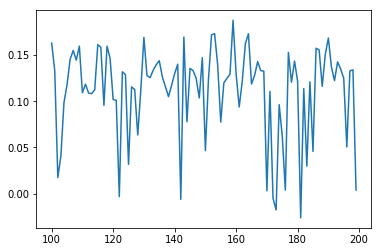

In [55]:
print(fimap_top.loc[fimap_top['y']==1, 'GATA3'].median())
fimap_top.loc[fimap_top['y']==1, 'GATA3'].plot();

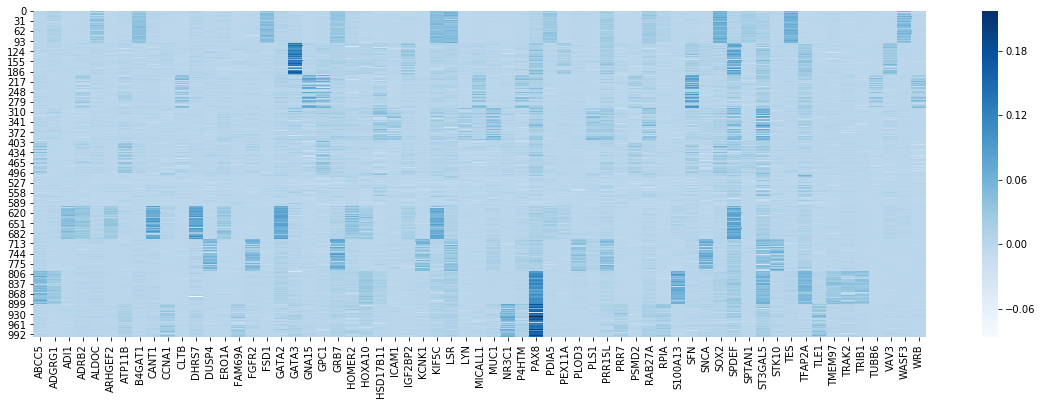

In [56]:
plt.figure(figsize=(20, 6))
sns.heatmap(fimap_top.iloc[:,2:], cmap='Blues');

### Heatmap per class

In [63]:
# Average importance for each feature and label
# fimap_top_label = fimap_top.groupby(by=['y', 'label']).agg(np.median).reset_index()
fimap_top_label = fimap_top.groupby(by=['y', 'label']).agg(np.mean).reset_index()
# fimap_top_label = fimap_top.groupby(by=['y', 'label']).agg(np.sum).reset_index()
print(fimap_top_label.shape)
fimap_top_label.iloc[:3,:4]

(10, 65)


,y,label,ABCC5,ADGRG1
0,0,Brain [LGG],0.002390,0.009986
1,1,Breast [BRCA],0.001918,0.003238
2,2,Head&Neck [HNSC],0.003199,0.000616


In [64]:
map_plot = fimap_top_label.drop(columns='y')
map_plot = map_plot.set_index('label')
map_plot.index.name = ''

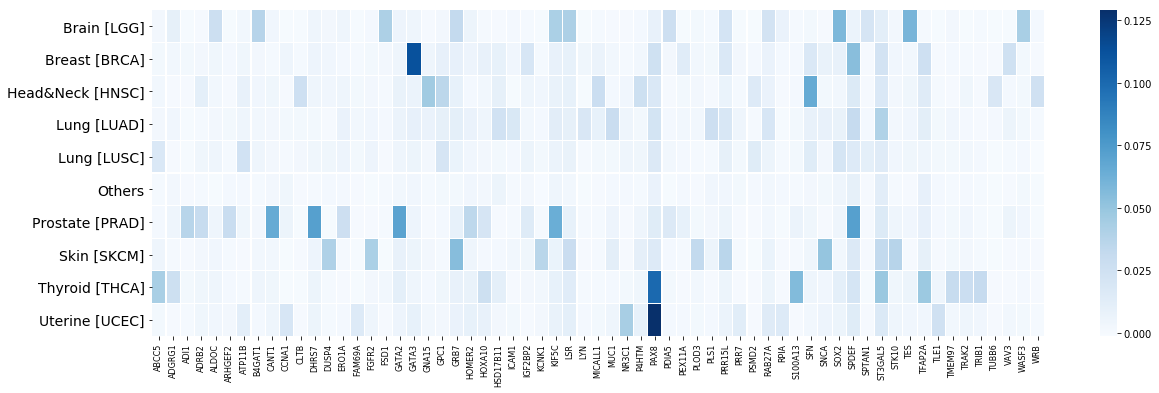

In [65]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(map_plot, cmap='Blues', linewidths=0.1, linecolor='white', xticklabels=map_plot.columns);
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
[tick.label.set_fontsize(8) for tick in ax.xaxis.get_major_ticks()];

In [27]:
top_fi_per_label(fimap_label_dict, c=c, n_top_cols=10).index[:5].tolist()

Lung [LUAD]


['ST3GAL5', 'SPDEF', 'MUC1', 'HSD17B11', 'PLS1']

In [28]:
c=1
top_fi_per_label(fimap_label_dict, c=c, n_top_cols=10)

Breast [BRCA]


GATA3      0.122745
SPDEF      0.062632
TFAP2A     0.029008
VAV3       0.027473
ST3GAL5    0.025714
PAX8       0.022621
IGF2BP2    0.021836
SFN        0.018837
PRR15L     0.017927
PEX11A     0.014850
dtype: float64

https://blog.algorexhealth.com/2017/09/10-heatmaps-10-python-libraries/

In [29]:
# import pandas as pd
# import numpy as np
# import holoviews as hv
# hv.extension('bokeh');

In [30]:
# # from bokeh.charts import HeatMap, output_file, show
# hv.HeatMap(map_plot)

In [31]:
# %%opts HeatMap [tools=['hover'] colorbar=True width=500 height=500 toolbar='above']
# hv.HeatMap(map_plot);

In [32]:
# hv.help(hv.HeatMap)